In [2]:
import numpy as np
import powerlaw
import matplotlib.pyplot as plt
import scipy.stats
plt.style.use('seaborn-paper')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 150

/var/folders/77/jfwlc7mn17nftm69gps4bk640000gn/T/ipykernel_8083/354749697.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [17]:
"""Settings."""
d = 100 # dimension
k = 4 # sparsity
n = 2000 # sample size
K = 300 # number of subgroups
p = 0.05 # corruption probability
mu = np.zeros(d)
mu_sparse = [5, -2, -1.5, 2]
mu[:k] = mu_sparse
mu = mu.reshape((d, 1))
trial_num = 10
eta = 0.07
rho = 1
max_iter = 2000
variance = 3.3

In [30]:
"""GD."""
pred_5 = np.zeros((trial_num, max_iter, d, 1))
for trial in range(trial_num):
    # initialize the dataset
    # X = np.random.normal(0, 1, size=(n, d))
    X = np.empty((n, d))
    # power law distribution
    # alpha = 2.5
    # xmin = 1
    # mean = np.zeros((n, d))
    # mean += (alpha / (alpha - 1)) * xmin
    # dist = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
    # for i in range(n):
    #     X[i, :] = dist.generate_random(d)
    # X = X - mean
    for i in range(n):
        for j in range(d):
            X[i][j] = variance * np.random.lognormal() * (2 * np.random.randint(0,2) - 1)

    for i in range(k):
        X[:, i] += mu_sparse[i]

    # Add corrupted data
    for j in range(np.floor(p * n).astype(int)):
        X[j, :] = 40 + 50 * np.random.standard_cauchy(size=(1, d)) # non-standard Cauchy, mean 20, scale 50

    idx = np.arange(n)
    np.random.shuffle(idx)

    idx_split = np.array_split(idx, K)
    X_grouped = []
    for i in range(K):
        idx_tmp = idx_split[i]
        X_tmp = [X[j] for j in idx_tmp]
        X_grouped.append(list(np.mean(X_tmp, axis = 0)))
    
    # X_split = np.array_split(S, K)
    # X_grouped = []
    # for i in X_split:
    #     X_grouped.append(list(np.mean(i, axis = 0)))
    #X_grouped = np.mean(X_grouped, axis=1)
    X_grouped = np.array(X_grouped)

    print(X_grouped)

    # Grouping preprocessing
    # X_grouped = np.split(X, K)
    # X_grouped = np.mean(X_grouped, axis=1)

    # initialize the parameters
    alpha = 1e-10
    u = alpha * np.ones((d, 1))
    v = alpha * np.ones((d, 1))
    dists = np.zeros(max_iter)
    error = np.zeros((max_iter, d, 1))
    pred = np.zeros((max_iter, d, 1))
    for t in range(max_iter):
        grad_u = np.zeros((d, 1))
        grad_v = np.zeros((d, 1))
        for i in range(K):
            grad_u += -np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * u
            grad_v += np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * v
        u -= eta * grad_u / K
        v -= eta * grad_v / K
        eta *= rho
        dists[t] = np.linalg.norm(u * u - v * v - mu, ord=1)
        error[t] = abs(u * u - v * v - mu)
        pred[t] = abs(u * u - v * v)
        pred_5[trial][t] = pred[t]
print(pred_5.shape)
pred_5 = np.transpose(pred_5, (2, 1, 0, 3))
print(pred_5.shape)

[[-4.75396790e-01 -4.41418546e+00 -3.26751055e+00 ...  2.89298782e+00
  -2.42234553e+00  5.31435983e-03]
 [-1.78291538e+02  5.52599512e+00 -1.69181061e+00 ... -4.03736625e+00
   1.57119692e+01  1.78643695e+01]
 [ 6.76618689e+00  1.20013542e+01  7.97321765e+00 ... -1.91967933e+01
   9.71254605e+00  3.34221336e+00]
 ...
 [-5.60577748e+00  4.36876469e-01 -1.39132173e+01 ... -1.06167698e+01
   1.47892813e+01 -2.26899000e+00]
 [ 6.76025351e+00  7.00647225e+00  1.72529677e+00 ... -1.48609799e+00
  -3.33567132e+00 -2.75339374e+00]
 [ 6.88468955e+00 -2.64628558e+00 -4.26908982e+00 ...  1.17210993e-01
   1.32632064e+00  1.06995616e+00]]
[[ 1.78645522e+01  5.21616641e+00  1.61064656e+02 ...  2.57993955e+00
   1.44303064e+00  2.34752464e+00]
 [ 4.41995462e+00  1.33478185e-01  6.10148015e+00 ...  2.32632045e+00
  -6.32550242e+00 -5.62528996e+00]
 [ 4.02634652e+00 -1.22050554e-01 -1.29134516e+00 ...  8.51474927e+00
  -1.30989325e+00 -1.88229136e+00]
 ...
 [ 1.23945164e+01 -6.15325427e-01  3.2977888

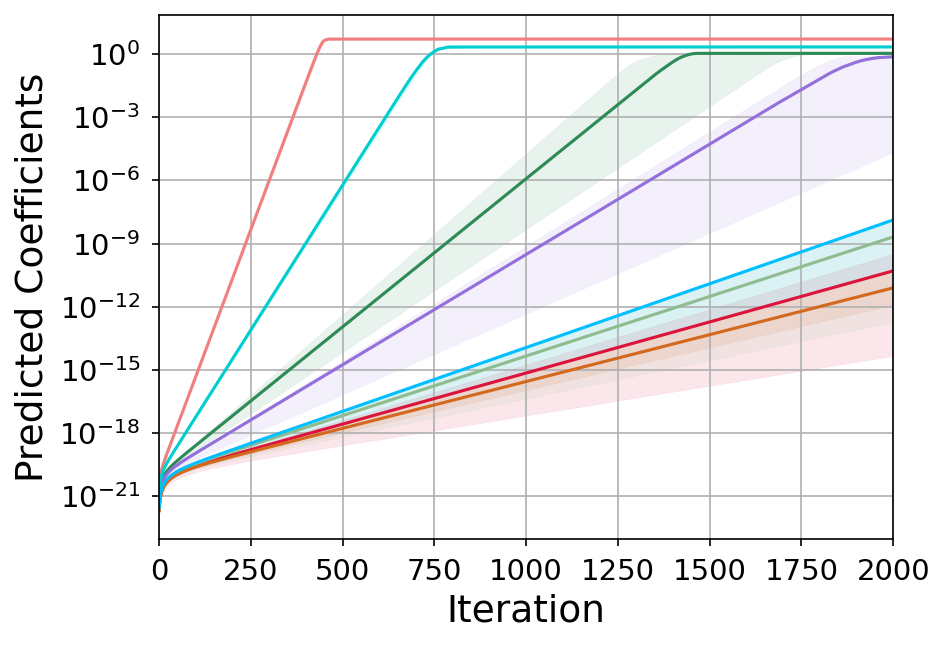

In [31]:
"""Prediction plots."""
point_num = 8
mins = np.zeros((d, max_iter))
maxs = np.zeros((d, max_iter))
med = np.zeros((d, max_iter))
# col = [None for _ in range(point_num)]
col = ['lightcoral', 'seagreen', 'mediumpurple', 'darkturquoise', 'crimson', 'darkseagreen', 'chocolate', 'deepskyblue', 'orange', 'dimgray']

for i in range(point_num):
    # col[i] = (np.random.random(), np.random.random(), np.random.random())
    for t in range(max_iter):
        sorted = np.sort(pred_5[i][t], axis=0)
        mins[i][t] = sorted[1]
        med[i][t] = sorted[2]
        maxs[i][t] = sorted[3]
    plt.fill_between(list(range(max_iter)), mins[i], maxs[i], color=col[i], alpha=0.1)
    plt.plot(med[i], color=col[i], linewidth=1.5, label=f'$\\mu_{i}(t)$')
plt.xlim(0, max_iter)
plt.yscale('log')
plt.ylabel('Predicted Coefficients')
plt.xlabel('Iteration')
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
# plt.legend(loc='upper right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.grid(True)
plt.tight_layout()
# plt.title(f'The predicted coefficients of the first {point_num} coordinates varied with time.')

plt.savefig(f"../figs/nonconvex-epsilon={p}-variance={variance}-mu={mu_sparse}.pdf")
plt.show()

In [20]:
"""Single-variable GD."""
pred_5 = np.zeros((trial_num, max_iter, d, 1))
for trial in range(trial_num):
    # initialize the dataset
    # X = np.random.normal(0, 1, size=(n, d))
    X = np.empty((n, d))
    # # power law distribution
    # alpha = 2.5
    # xmin = 1
    # mean = np.zeros((n, d))
    # mean += (alpha / (alpha - 1)) * xmin
    # dist = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
    # for i in range(n):
    #     X[i, :] = dist.generate_random(d)
    # X = X - mean
    for i in range(n):
        for j in range(d):
            X[i][j] = variance * np.random.lognormal() * (2 * np.random.randint(0,2) - 1)
    for i in range(k):
        X[:, i] += mu_sparse[i]

    # Add corrupted data
    for j in range(np.floor(p * n).astype(int)):
        X[j, :] = 40 + 50 * np.random.standard_cauchy(size=(1, d)) # non-standard Cauchy, mean 20, scale 50

    idx = np.arange(n)
    np.random.shuffle(idx)

    idx_split = np.array_split(idx, K)
    X_grouped = []
    for i in range(K):
        idx_tmp = idx_split[i]
        X_tmp = [X[j] for j in idx_tmp]
        X_grouped.append(list(np.mean(X_tmp, axis = 0)))
    
    # X_split = np.array_split(S, K)
    # X_grouped = []
    # for i in X_split:
    #     X_grouped.append(list(np.mean(i, axis = 0)))
    #X_grouped = np.mean(X_grouped, axis=1)
    X_grouped = np.array(X_grouped)

    print(X_grouped)

    # initialize the parameters
    alpha = 1e-3
    u = alpha * np.ones((d, 1))
    dists = np.zeros(max_iter)
    error = np.zeros((max_iter, d, 1))
    pred = np.zeros((max_iter, d, 1))
    for t in range(max_iter):
        grad_u = np.zeros((d, 1))
        grad_v = np.zeros((d, 1))
        for i in range(K):
            grad_u += -np.sign(X_grouped[i, :].reshape((d, 1)) - u)
        u -= eta * grad_u / K
        eta *= rho
        dists[t] = np.linalg.norm(u - mu, ord=1)
        error[t] = abs(u - mu)
        pred[t] = abs(u)
        pred_5[trial][t] = pred[t]
print(pred_5.shape)
pred_5 = np.transpose(pred_5, (2, 1, 0, 3))
print(pred_5.shape)

[[ 1.38549402e+01 -5.88661534e+01 -5.80422023e+00 ...  1.14988371e+01
   1.20337046e+01  2.07551777e+01]
 [ 1.55927114e+01 -5.46304174e+00  7.87282847e+00 ...  8.36594399e+00
   1.70203808e+01  1.58824170e+01]
 [ 2.85686273e+00  5.69625430e+00  3.35088848e+00 ... -9.41991499e-01
  -9.94661595e-01 -3.56255762e+00]
 ...
 [ 4.72491822e+00 -2.49206565e-01  1.08810166e+00 ... -4.42553652e+00
   9.32179632e-01 -1.03445264e+00]
 [-1.06360750e+00 -4.34673295e+00 -1.30413821e-02 ... -3.52796997e+00
  -7.33979025e+00 -3.61515220e+00]
 [ 6.70923138e+00 -2.25990416e+00 -2.84192535e+00 ... -4.43927424e-01
  -2.91123516e+00 -2.82552737e+00]]
[[-0.88502935  1.99423855 -0.68528539 ...  0.97190884 -3.19531777
  -3.91156512]
 [10.94609762 -6.75928568 -3.96964516 ... -1.12238389  2.70055588
   6.76305651]
 [ 7.78998106 -2.27728042  0.02534435 ... -2.23793402 -0.80978522
   0.23206285]
 ...
 [ 6.7714257  -3.91774429  1.55869191 ... -0.20763557 -0.9136654
  -0.20413714]
 [ 2.72540513 -1.69142318  2.4600045

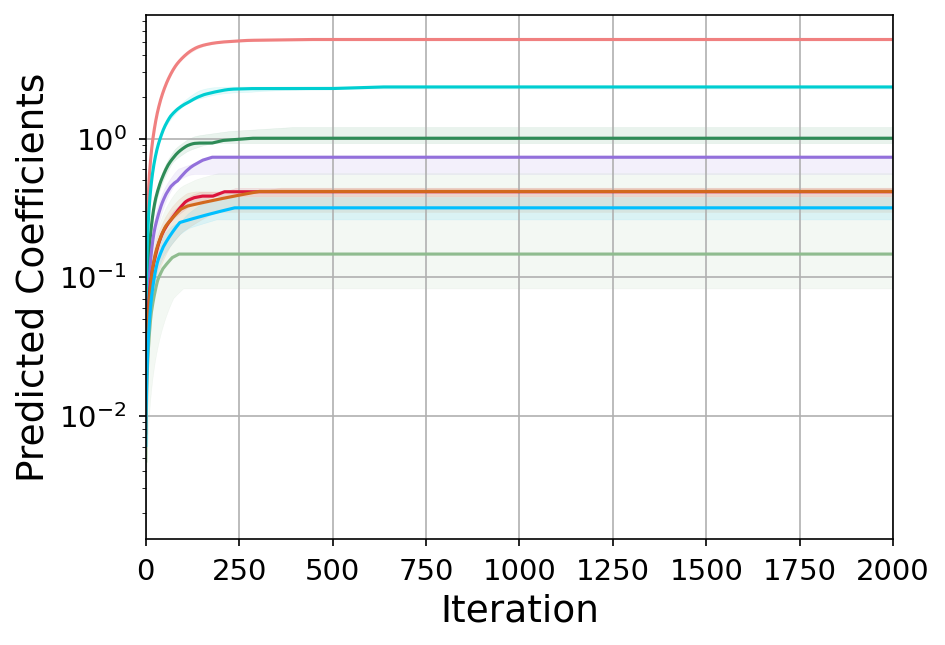

In [29]:
"""Prediction plots."""
point_num = 8
mins = np.zeros((d, max_iter))
maxs = np.zeros((d, max_iter))
med = np.zeros((d, max_iter))
# col = [None for _ in range(point_num)]
col = ['lightcoral', 'seagreen', 'mediumpurple', 'darkturquoise', 'crimson', 'darkseagreen', 'chocolate', 'deepskyblue', 'orange', 'dimgray']

for i in range(point_num):
    # col[i] = (np.random.random(), np.random.random(), np.random.random())
    for t in range(max_iter):
        sorted = np.sort(pred_5[i][t], axis=0)
        mins[i][t] = sorted[1]
        med[i][t] = sorted[2]
        maxs[i][t] = sorted[3]
    plt.fill_between(list(range(max_iter)), mins[i], maxs[i], color=col[i], alpha=0.1)
    plt.plot(med[i], color=col[i], linewidth=1.5, label=f'$\\mu_{i}(t)$')
plt.xlim(0, max_iter)
plt.yscale('log')
plt.ylabel('Predicted Coefficients')
plt.xlabel('Iteration')
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
# plt.legend(loc='upper right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.grid(True)
plt.tight_layout()
# plt.title(f'The predicted coefficients of the first {point_num} coordinates varied with time.')

plt.savefig(f"../figs/convex-epsilon={p}-variance={variance}-mu={mu_sparse}.pdf")
plt.show()

In [13]:
"""Settings."""
d = 100 # dimension
k = 4 # sparsity
n = 800 # sample size
p = 0.05 # corruption probability
K = int(2*p*n) # number of subgroups
mu = np.zeros(d)
mu_sparse = 2 * np.ones(k)
mu[:k] = mu_sparse
mu = mu.reshape((d, 1))
trial_num = 10
eta = 0.05
rho = 1
max_iter = 1000
variance = 1

In [14]:
"""GD."""
pred_5 = np.zeros((trial_num, max_iter, d, 1))
for trial in range(trial_num):
    # initialize the dataset
    # X = np.random.normal(0, 1, size=(n, d))
    X = np.empty((n, d))
    # power law distribution
    # alpha = 2.5
    # xmin = 1
    # mean = np.zeros((n, d))
    # mean += (alpha / (alpha - 1)) * xmin
    # dist = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
    # for i in range(n):
    #     X[i, :] = dist.generate_random(d)
    # X = X - mean
    
    for i in range(n):
        for j in range(d):
            #X[i][j] = variance * np.random.lognormal() * (2 * np.random.randint(0,2) - 1)
            X[i][j] = 4 * variance * scipy.stats.pareto.rvs(2.74) * (2 * np.random.randint(0,2) - 1)
    
    #X = variance * scipy.stats.t.rvs(2.74,size = (n,d))
    #X = variance * np.random.randn(n,d)

    for i in range(k):
        X[:, i] += mu_sparse[i]

    # Add corrupted data
    for j in range(np.floor(p * n).astype(int)):
        #X[j, :] = 40 + 50 * np.random.standard_cauchy(size=(1, d)) # non-standard Cauchy, mean 20, scale 50
        X[j, :] += -2

    idx = np.arange(n)
    np.random.shuffle(idx)

    idx_split = np.array_split(idx, K)
    X_grouped = []
    for i in range(K):
        idx_tmp = idx_split[i]
        X_tmp = [X[j] for j in idx_tmp]
        X_grouped.append(list(np.mean(X_tmp, axis = 0)))
    
    # X_split = np.array_split(S, K)
    # X_grouped = []
    # for i in X_split:
    #     X_grouped.append(list(np.mean(i, axis = 0)))
    #X_grouped = np.mean(X_grouped, axis=1)
    #print(X_grouped)
    X_grouped = np.array(X_grouped)

    # Grouping preprocessing
    # X_grouped = np.split(X, K)
    # X_grouped = np.mean(X_grouped, axis=1)
    
    # initialize the parameters
    alpha = 1e-5
    u = alpha * np.ones((d, 1))
    v = alpha * np.ones((d, 1))
    dists = np.zeros(max_iter)
    error = np.zeros((max_iter, d, 1))
    pred = np.zeros((max_iter, d, 1))
    for t in range(max_iter):
        grad_u = np.zeros((d, 1))
        grad_v = np.zeros((d, 1))
        for i in range(K):
            grad_u += -np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * u
            grad_v += np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * v
        u -= eta * grad_u / K
        v -= eta * grad_v / K
        eta *= rho
        dists[t] = np.linalg.norm(u * u - v * v - mu, ord=1)
        error[t] = abs(u * u - v * v - mu)
        pred[t] = abs(u * u - v * v)
        pred_5[trial][t] = pred[t]
print(pred_5.shape)
pred_5 = np.transpose(pred_5, (2, 1, 0, 3))
print(pred_5.shape)

(10, 1000, 100, 1)
(100, 1000, 10, 1)


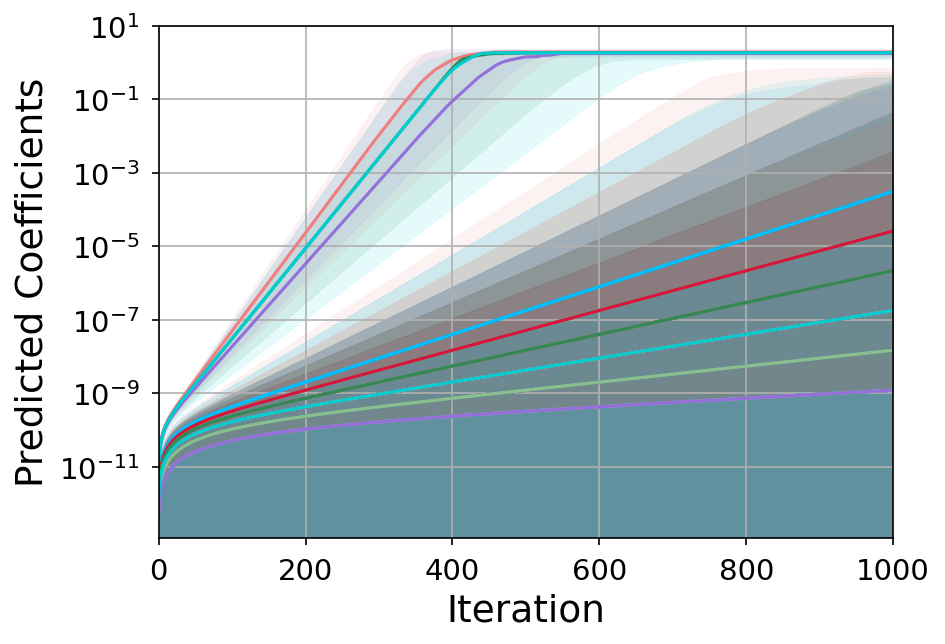

In [20]:
"""Prediction plots."""
point_num = 8
mins = np.zeros((d, max_iter))
maxs = np.zeros((d, max_iter))
med = np.zeros((d, max_iter))
# col = [None for _ in range(point_num)]
col = ['lightcoral', 'seagreen', 'mediumpurple', 'darkturquoise', 'crimson', 'darkseagreen', 'chocolate', 'deepskyblue', 'orange', 'dimgray']

for i in range(d):
    # col[i] = (np.random.random(), np.random.random(), np.random.random())
    for t in range(max_iter):
        sorted = np.sort(pred_5[i][t], axis=0)
        mins[i][t] = sorted[0]
        med[i][t] = sorted[trial // 2]
        maxs[i][t] = sorted[-2]
    plt.fill_between(list(range(max_iter)), mins[i], maxs[i], color=col[i%8], alpha=0.1)
    plt.plot(med[i], color=col[i%8], linewidth=1.5, label=f'$\\mu_{i}(t)$')
plt.xlim(0, max_iter)
plt.yscale('log')
plt.ylabel('Predicted Coefficients')
plt.xlabel('Iteration')
plt.xticks(color='k', fontsize=14)
plt.yticks(color='k', fontsize=14)
# plt.legend(loc='upper right', prop={'size': 18})
axes = plt.gca()
axes.xaxis.label.set_size(18)
axes.yaxis.label.set_size(18)
plt.grid(True)
plt.tight_layout()
# plt.title(f'The predicted coefficients of the first {point_num} coordinates varied with time.')

#plt.savefig(f'figs/convex-epsilon={p}-variance={variance}-mu={mu_sparse}.pdf')
plt.show()